# Creating a GHZ state with topology in mind

Creating a GHZ state is a great first job to run on any quantum computing system to get a feeling for the performance.

In this notebook, you will ...
* ... run and compare a GHZ state as implemented naively and with respect to the qubit connectivity of the IQM quantum processor.

In order to get started, change your runtime environment to 2025.07 (in the top toolbar, Runtime -> Change runtime environment) and then make sure you have the appropriate packages installed:

In [ ]:
!pip install --upgrade pip
!pip install "iqm-client[qiskit]"
!pip install qrisp[iqm]
!pip install numpy==2.0
!pip install matplotlib
!pip install pylatexenc

  Using cached qrisp-0.7.15-py3-none-any.whl.metadata (7.1 kB)
  Using cached sympy-1.13.0-py3-none-any.whl.metadata (12 kB)
  Using cached Flask-2.2.5-py3-none-any.whl.metadata (3.9 kB)
  Using cached waitress-3.0.2-py3-none-any.whl.metadata (5.8 kB)
  Using cached jax-0.6.0-py3-none-any.whl.metadata (22 kB)
  Using cached jaxlib-0.6.0-cp311-cp311-manylinux2014_x86_64.whl.metadata (1.2 kB)
  Using cached iqm_client-32.1.1-py3-none-any.whl.metadata (17 kB)
  Using cached ml_dtypes-0.5.4-cp311-cp311-manylinux_2_27_x86_64.manylinux_2_28_x86_64.whl.metadata (8.9 kB)
  Using cached iqm_station_control_client-11.3.1-py3-none-any.whl.metadata (14 kB)
  Using cached iqm_exa_common-27.4.0-py3-none-any.whl.metadata (14 kB)
  Using cached qiskit-1.4.2-cp39-abi3-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (12 kB)
  Using cached symengine-0.13.0-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (1.2 kB)
  Using cached numpy-2.0.2-cp311-cp311-manylinux_2_17_x86_64.many

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for pylatexenc: filename=pylatexenc-2.10-py3-none-any.whl size=136897 sha256=176c1018e69ae8762fa8b9292baddfb67cb976d5c87323b6371a4604fd55f419
  Stored in directory: /root/.cache/pip/wheels/b1/7a/33/9fdd892f784ed4afda62b685ae3703adf4c91aa0f524c28f03
Successfully built pylatexenc


## 1. Preparation

### 1.1 Connecting to the QPU
First, we need to define the QPU we want to work with by creating a backend object. In order to access the system, you will need the correct url and token.

We're going to be using some functions from Qiskit for this lab, so the connection to the quantum computer looks a little different than we've seen in previous exercises.

In [ ]:
from iqm.qiskit_iqm import IQMProvider

provider = IQMProvider("https://resonance.meetiqm.com",
                       quantum_computer="emerald",
                       token=input("Input your IQM Resonance token"))
backend = provider.get_backend()

fQTYROxn0R2lY7W22DJjG1WWJ7d1iAe4Wr3gvTN0SF4Bml2bDoh7YL9b1V2EdkA2



### 1.2 Visualizing the qubits
Now we can access the system and plot its connectivity graph to check that everything is working properly. Each dot represents a qubit and each line represents coupling between those qubits.

Compare this graph to what is shown on the IQM Resonance webpage. What looks the same? What looks different? (Hint: What is the smallest-numbered qubit on each?)

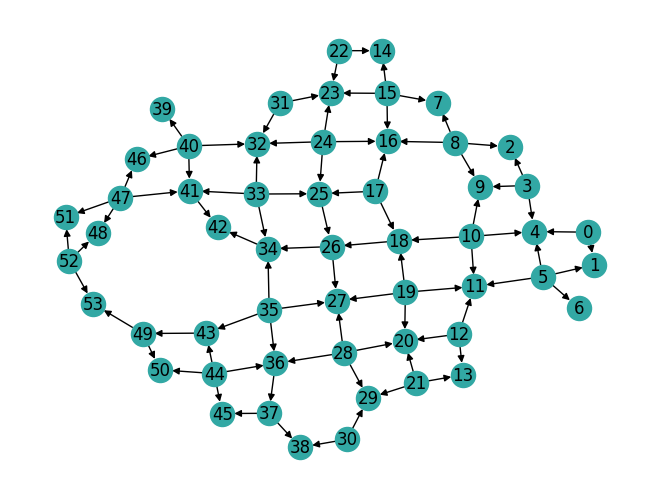

In [ ]:
from rustworkx.visualization import mpl_draw
from rustworkx import spring_layout

mpl_draw(backend.coupling_map.graph, arrows=True, with_labels=True, node_color='#32a8a4', pos=spring_layout(backend.coupling_map.graph, num_iter=200))

## 2. Creating a GHZ state

The GHZ (Greenberger-Horne-Zeilinger) state is a maximally entangled quantum state that involves three or more qubits. It is an equal superposition of all qubits being in state 0 and all qubits being in state 1. We will first use 3 qubits of the 54 we have available on the system; this can be represented as:

$$\frac{1}{\sqrt{2}}(∣000⟩+ ∣111⟩)$$

In order to create a GHZ state, we follow the steps below:

<ol>
<li> First, we initiate the process by <b>creating a superposition</b> using a Hadamard gate <span style="    display: inline-block; min-width: 1.7rem; text-align: center; background: linear-gradient(0.45turn, rgba(255, 255, 255, 0.1), rgba(0, 0, 0, 0.05)) rgb(80, 90, 98); color: white; padding: 0.1rem; margin: 0.05rem; font-weight: 600; border-radius: 0.2rem;">H</span> on a qubit.
</li>
<li>  Then, we <b>apply <span style="display: inline-block; min-width: 1.7rem; text-align: center; background: linear-gradient(0.45turn, rgba(255, 255, 255, 0.1), rgba(0, 0, 0, 0.05)) rgb(80, 90, 98); color: white; padding: 0.1rem; margin: 0.05rem; font-weight: 600; border-radius: 0.2rem;">CNOT</span> gates from one qubit to two other qubits</b>.
</li>
<li> Finally, we perform <b>measurements on all qubits.
</li>
</ol>

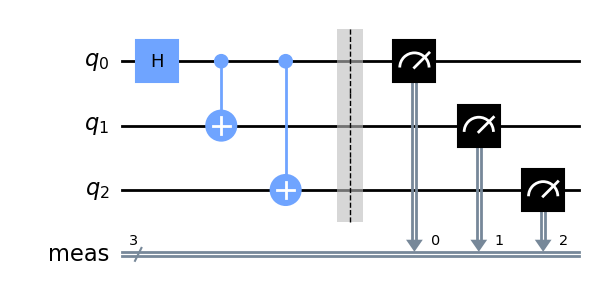

In [ ]:
# This syntax will look a little different than you're used to because we need to use Qiskit in order to do custom transpilation later.

from qiskit import QuantumCircuit

num_qb = 3
# Instead of QuantumVariable, we use QuantumCircuit
qc = QuantumCircuit(num_qb)

# Instead of h(qc[0]), we write qc.h(0). Use similar syntax for other gates.
qc.h(0)
for qb in range(1, num_qb):
    qc.cx(0, qb)

qc.measure_all()
qc.draw("mpl",  style="clifford")


Executing it is then simply a matter of running the circuit on the backend.

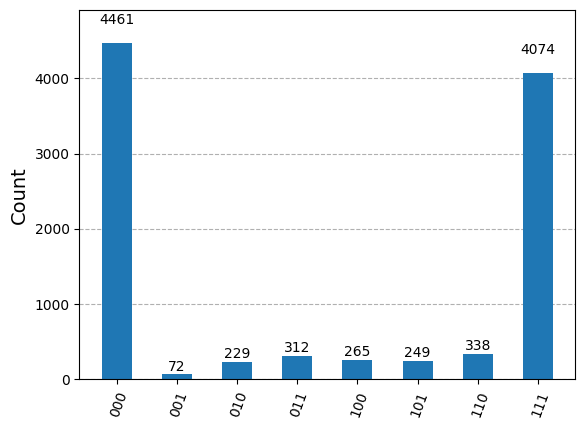

In [ ]:
from qiskit.visualization import plot_histogram
from qiskit import transpile

shots = 10000
# again, this looks a little bit different because we're in Qiskit instead of qrisp.
qc_transpiled = transpile(qc, backend=backend)
job = backend.run(qc_transpiled, shots=shots)

res=job.result()
counts=res.get_counts()

plot_histogram(counts)

## 3. Creating the GHZ state on a different set of qubits

When running a circuit with fewer qubits than available, we have the possibility to choose the most performant qubits in the QPU.

**Task: Fill in and execute the two code blocks below to create a GHZ state on two different sets of qubits.**

Use the topology of the system to choose a more efficient set of qubits for a GHZ states. Execute them on the real quantum computer and compare the outcomes.

In [ ]:
qubits_names_1 = [
    #Labels for the qubits that we're going to use
    "QB1",
    "QB2",
    "QB5",
]

qubits_names_2 = [
#TODO: Pick another set of 3 qubits, ideally the best-performing ones that you can!
   "QB8",
   "QB16",
   "QB9"
]

# Qiskit identifies qubits with integers, so we need to convert those string by using the IQM Backend method
qubits_1 = [backend.qubit_name_to_index(name) for name in qubits_names_1]
qubits_2 = [backend.qubit_name_to_index(name) for name in qubits_names_2]

# Shows the couplings between the qubits we have selected without showing any of the others.
# Importantly, the first qubit on Qiskit is qubit 0, while the first qubit on Resonance is QB1. So QB1 on Resonance corresponds to qubit 0
#   in Qiskit, and QB5 on Resonance corresponds to QB4 on Qiskit.
reduced_coupling_map_1 = [list(edge) for edge in backend.coupling_map if set(edge).issubset(set(qubits_1))]
print("Reduced coupling map: ", reduced_coupling_map_1)
reduced_coupling_map_2 = [list(edge) for edge in backend.coupling_map if set(edge).issubset(set(qubits_2))]
print("Reduced coupling map: ", reduced_coupling_map_2)

Reduced coupling map:  [[0, 1], [0, 4]]
Reduced coupling map:  [[8, 7], [15, 7]]


Keep in mind the reduced coupling maps above to choose on which qubit you should apply the Hadamard and the CNOT gates.

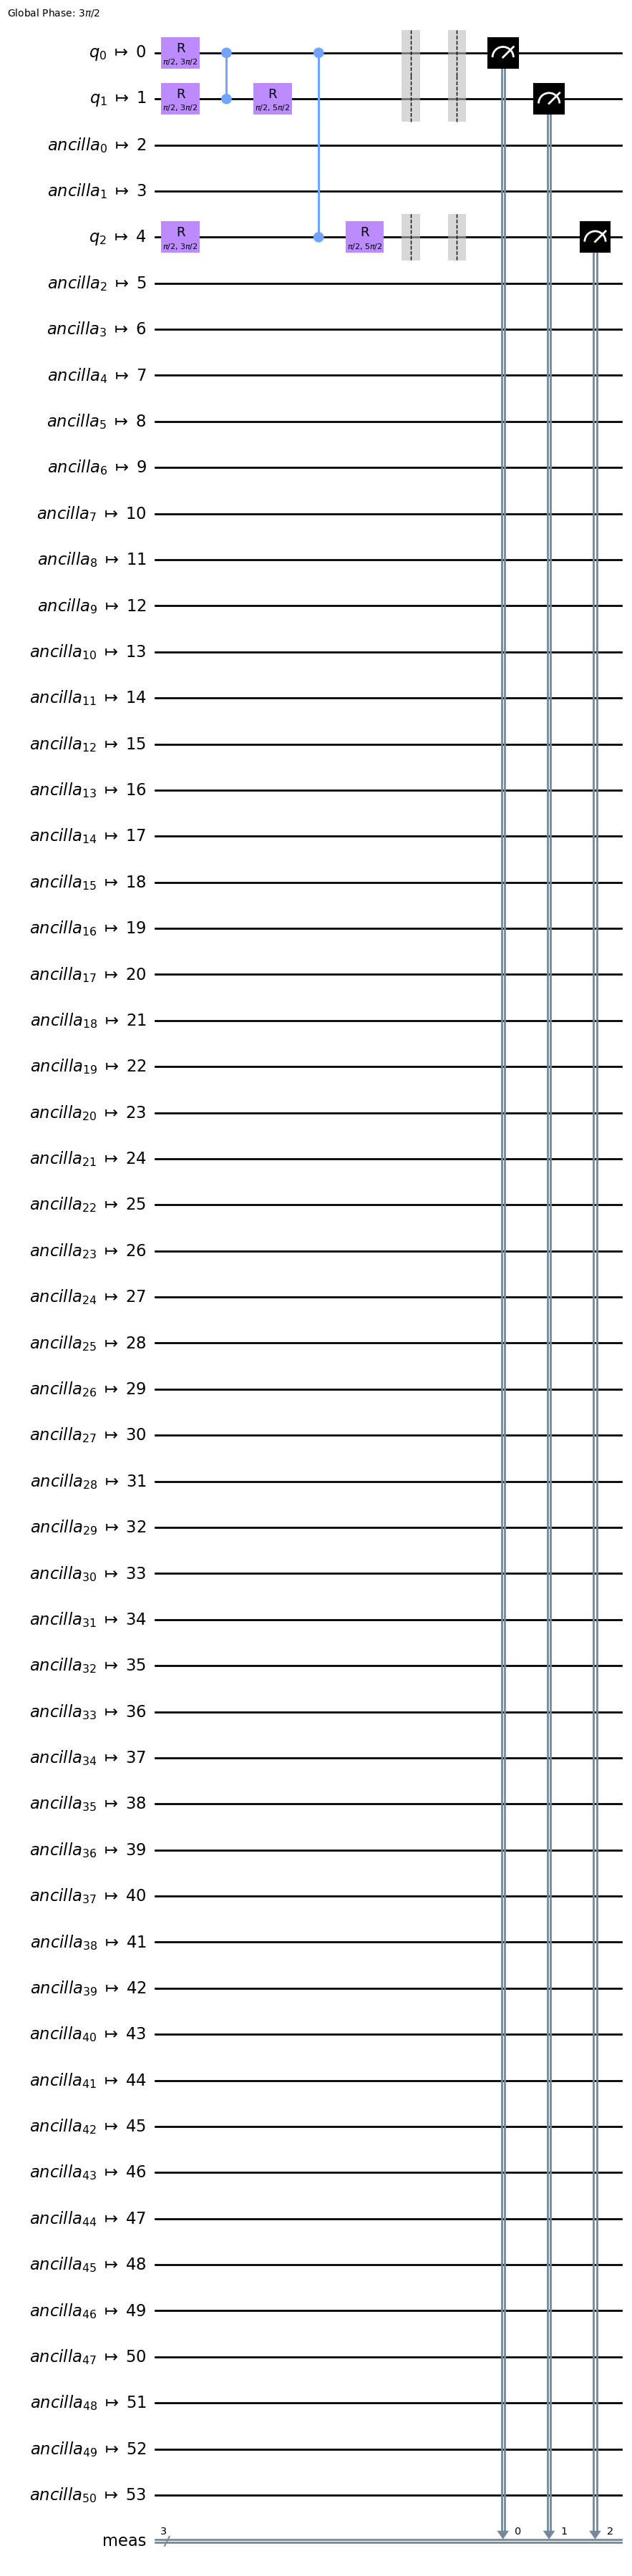

In [ ]:
qc1 = QuantumCircuit(num_qb)
# TODO: Add the circuit that acts on qubits_1

qc1.h(0)
for qb in range(1, num_qb):
    qc1.cx(0, qb)

qc1.barrier()
qc1.measure_all()

qc1_transpiled = transpile(qc1, backend, coupling_map=reduced_coupling_map_1, optimization_level=3)
qc1_transpiled.draw("mpl", style="clifford")

Copy and adapt the code cell above to make a GHZ state out of the qubits in the set qubits_2.

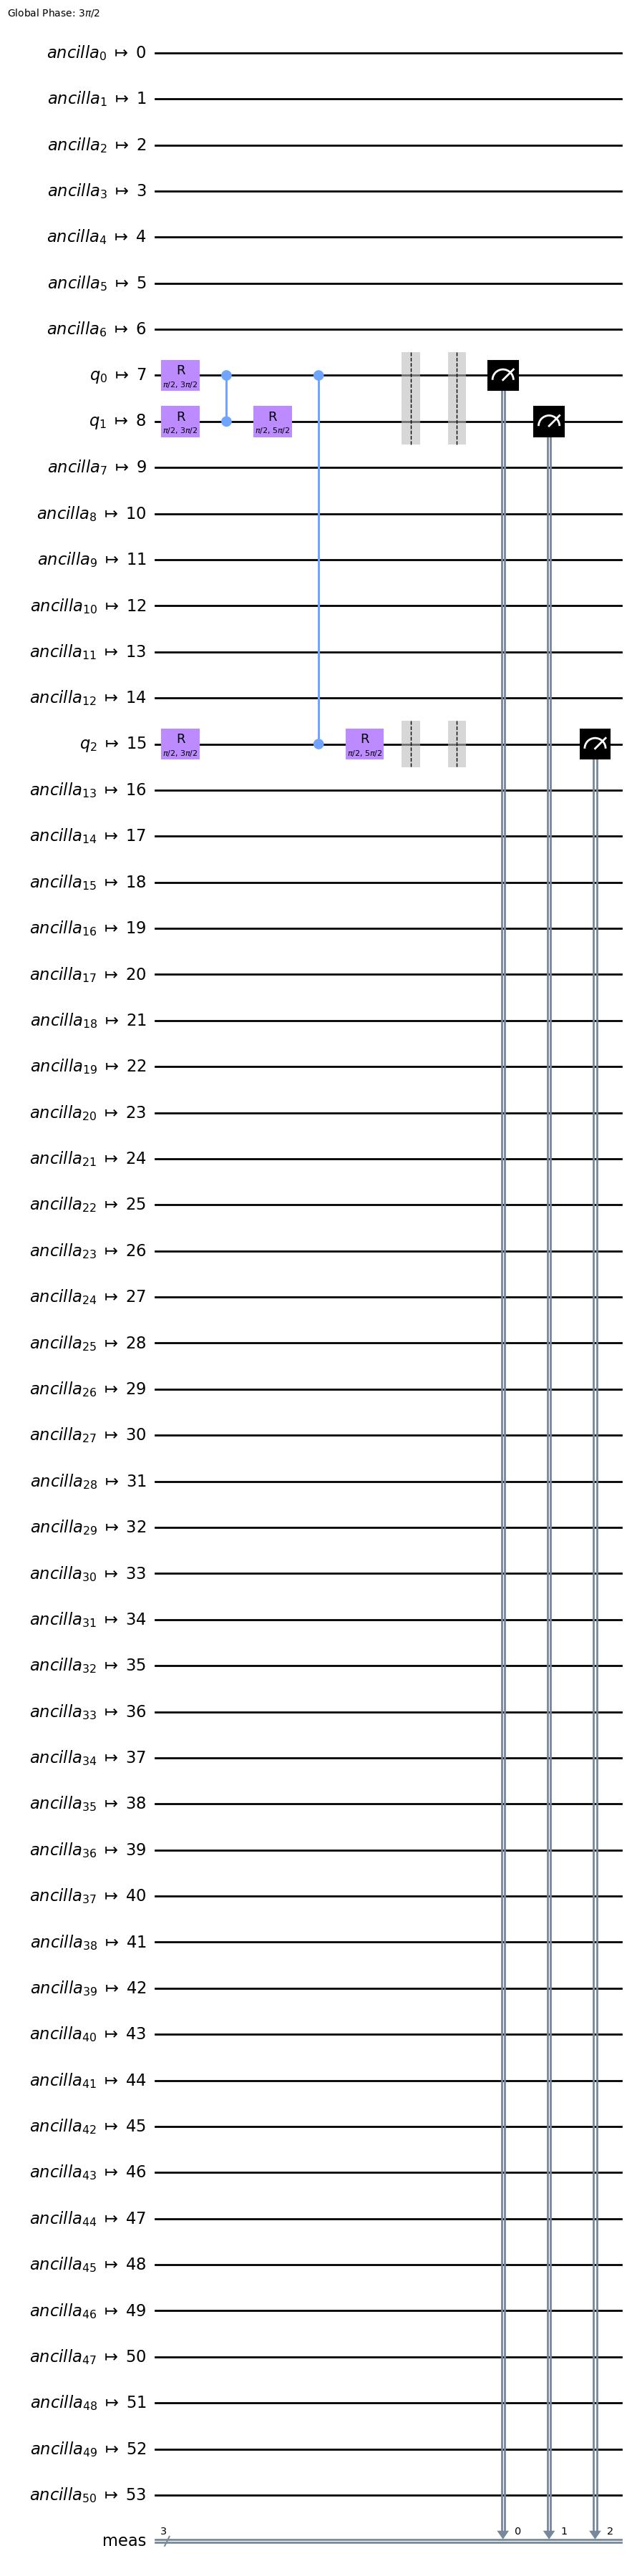

In [ ]:
# TODO: Add the circuit that acts on qubits_2

qc2 = QuantumCircuit(num_qb)

qc2.h(0)
for qb in range(1, num_qb):
    qc2.cx(0, qb)

qc2.barrier()
qc2.measure_all()

qc2_transpiled = transpile(qc2, backend, coupling_map=reduced_coupling_map_2, optimization_level=3)
qc2_transpiled.draw("mpl", style="clifford")

Finally, run the next two cells to run both circuits on Resonance and compare the results.

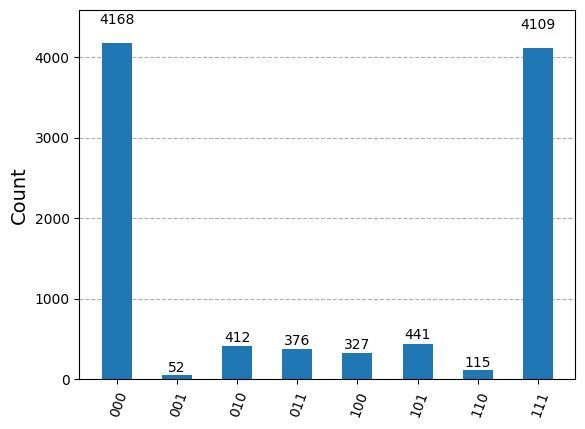

In [ ]:
shots = 10000
job1 = backend.run(qc1_transpiled, shots=shots)

res1=job1.result()
counts1=res1.get_counts()

plot_histogram(counts1)

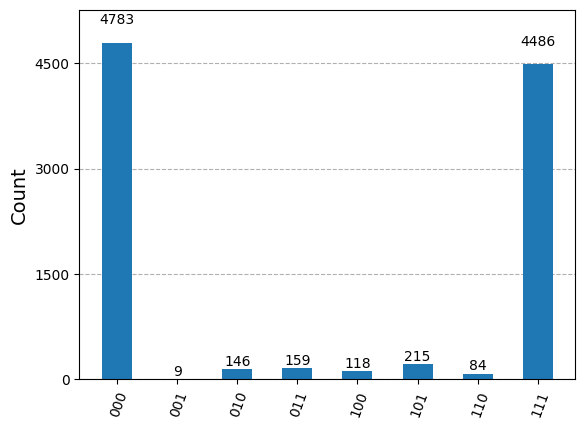

In [ ]:
job2 = backend.run(qc2_transpiled, shots=shots)

res2=job2.result()
counts2=res2.get_counts()

plot_histogram(counts2)

In [ ]:
# Copyright 2024 IQM Quantum Computers (Hermanni Heimonen, Stefan Seegerer, Stefan Pogorzalek, Nadia Milazzo)
#
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
#     http://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.